In [1]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import folium
from folium.plugins import MarkerCluster

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm

# %pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

**Data Preprocessing in team7-Final.ipynb**

In [2]:
# load data
cbsa = pd.read_csv("cbsa2.csv")
cbsa.head()

,number_of_providers,zone,in_range
0,3.0,central,True
1,18.0,pacific,True
2,11.0,central,True
3,5.0,central,True
4,18.0,eastern,True


**Split Data**

In [3]:
# split data
cbsa_train, cbsa_test = train_test_split(cbsa,
                                            test_size = 0.25,
                                            random_state = 7)

In [4]:
print('Original shape before partition: ', cbsa.shape[0],
        '\nTraining set shape: ', cbsa_train.shape[0],
        '\nTest set shape: ', cbsa_test.shape[0])

Original shape before partition:  162848 
Training set shape:  122136 
Test set shape:  40712


In [5]:
print('Proportion of training instances: ', cbsa_train.shape[0]/cbsa.shape[0]*100,
        '\nProportion of test instances: ', cbsa_test.shape[0]/cbsa.shape[0]*100)

Proportion of training instances:  75.0 
Proportion of test instances:  25.0


Balance Training Dataset

In [6]:
# response variable
cbsa_train['in_range'].value_counts()

in_range
True     121791
False       345
Name: count, dtype: int64

**Calculate ratio of minority class and find out how many to increase to get 30%**

In [7]:
# instances of minority divide by total instances
ratio = cbsa_train['in_range'].value_counts()[1] / cbsa_train.shape[0]*100
ratio

0.28247199842798193

imbalanced at 0.28%. False response will change depending on partition. Increase False response to 30%. For p(False) = 0.3, it needs X records to resample. Then, add to training set.

In [8]:
# isolate records to resample
to_resample = cbsa_train.loc[cbsa_train['in_range'] == False]
to_resample.shape[0]

345

In [9]:
cbsa_train.shape[0]

122136

In [10]:
p = 0.3
n = round(((p*cbsa_train.shape[0]) - to_resample.shape[0])/(1-p),0)
print(n)

51851.0


**Sample with replacement with 51851 records from the `False` class**

In [11]:
# sample from recods of interest
our_sample = to_resample.sample(n = 51851, replace = True)

In [12]:
# add sample to original training set
cbsa_train_rebal = pd.concat([cbsa_train, our_sample], axis = 0)

In [13]:
cbsa_train_rebal['in_range'].value_counts()

in_range
True     121791
False     52196
Name: count, dtype: int64

In [14]:
# confirm desiered % increase
ratio = cbsa_train_rebal['in_range'].value_counts()[1]/cbsa_train_rebal.shape[0]*100
ratio

29.99994252444148

In [15]:
cbsa_train_rebal.shape

(173987, 3)

**Modeling**

In [16]:
# metrics function
def calculate_metrics(model, TN, FP, FN, TP):
    # calculations
    TPN = TN + FN
    TPP = FP + TP
    TAN = TN + FP
    TAP = FN + TP
    GT = TN + FN + FP + TP
    
    accuracy = ((TN+TP)/GT)
    error_rate = 1 - accuracy
    sensitivity = TP/TAP
    specificity = TN/TAN
    precision = TP/TPP
    recall = sensitivity
    F1 = 2 * ((precision*recall)/(precision+recall))
    F2 = 5 * ((precision*recall)/((4*precision)+recall))
    F05 = 1.25 * ((precision*recall)/((0.25*precision)+recall))

    # Create a DataFrame with metric values
    values_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Error Rate', 'Sensitivity', 'Specificity', 
                   'Precision', 'Recall', 'F1 Score', 'F2 Score', 'F0.5 Score'],
        f'{model} Values': [accuracy, error_rate, sensitivity, specificity, 
                            precision, recall, F1, F2, F05]
    })

    return values_df

In [17]:
# split predictor and target variables into separate objects
X_train = cbsa_train_rebal.drop(['in_range'], axis=1)
y_train = cbsa_train_rebal['in_range']
X_train.head()

,number_of_providers,zone
65549,91.0,eastern
125888,12.0,pacific
83150,61.0,central
109998,9.0,eastern
110434,5.0,central


In [18]:
y_train

65549      True
125888     True
83150      True
109998     True
110434     True
          ...  
23294     False
23406     False
106306    False
60414     False
143774    False
Name: in_range, Length: 173987, dtype: bool

**Encode categoricals in training set**

In [19]:
X_train_numerical = X_train['number_of_providers']

In [20]:
train_encoded = pd.get_dummies(X_train['zone'])
train_encoded = train_encoded.astype(int)

# concatenate with rest of predictors
X_train = pd.concat([X_train_numerical, train_encoded], axis=1)
X_train

,number_of_providers,alaska,atlantic,central,eastern,hawaii,mountain,pacific
65549,91.0,0,0,0,1,0,0,0
125888,12.0,0,0,0,0,0,0,1
83150,61.0,0,0,1,0,0,0,0
109998,9.0,0,0,0,1,0,0,0
110434,5.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
23294,134.0,0,0,0,1,0,0,0
23406,63.0,0,0,0,1,0,0,0
106306,285.0,0,0,0,1,0,0,0
60414,603.0,0,0,1,0,0,0,0


**Train Model**

In [21]:
# train NB model using by passing predictor and target training
nb = MultinomialNB().fit(X_train, y_train)

**Encode categoricals in test set**

In [22]:
X_test = cbsa_test.drop(['in_range'], axis=1)
y_test = cbsa_test['in_range']

In [23]:
X_test_numerical = X_test['number_of_providers']

In [24]:
test_encoded = pd.get_dummies(X_test['zone'])
test_encoded = test_encoded.astype(int)

X_test = pd.concat([X_test_numerical, test_encoded], axis=1)

In [25]:
# make prediction on test set using nb model
nb_preds = nb.predict(X_test)

**Confusion Matrix**

In [26]:
nb_cm =confusion_matrix(y_test, nb_preds)

In [27]:
nb_cm

array([[   38,    78],
       [ 1686, 38910]], dtype=int64)

In [28]:
TN = nb_cm[0][0]
FP = nb_cm[0][1]
FN = nb_cm[1][0]
TP = nb_cm[1][1]

nb_metrics = calculate_metrics("nb1", TN, FP, FN, TP)
nb_metrics

,Metric,nb1 Values
0,Accuracy,0.956671
1,Error Rate,0.043329
2,Sensitivity,0.958469
3,Specificity,0.327586
4,Precision,0.997999
5,Recall,0.958469
6,F1 Score,0.977835
7,F2 Score,0.966122
8,F0.5 Score,0.989835


**Baseline Logistic Regression**

Goal: determine wether or not cbsa are in range for average total payment per user.

In [29]:
# add constant to rebalanced
X_1 = sm.add_constant(X_train)

In [30]:
# logistic regression with manual rebalanced samples
logreg01 = sm.Logit(y_train, X_1).fit()
logreg01.summary2()

         Current function value: 0.473119
         Iterations: 35


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:               Logit             Method:            MLE        
Dependent Variable:  in_range          Pseudo R-squared:  0.225      
Date:                2024-04-13 21:50  AIC:               164648.9835
No. Observations:    173987            BIC:               164729.5174
Df Model:            7                 Log-Likelihood:    -82316.    
Df Residuals:        173979            LL-Null:           -1.0628e+05
Converged:           0.0000            LLR p-value:       0.0000     
No. Iterations:      35.0000           Scale:             1.0000     
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const               11.2940      nan       nan    nan     nan     nan
number_of_providers -0.0077   0.0001 -135.0949 0.0000 -0.0078 -0.0076
alaska               8.3520      nan       nan    nan     nan     nan
atlantic            11.4467      nan       nan    nan     nan     nan
central             -9.3572      nan       nan    nan     nan     nan
eastern             -9.9328      nan       nan    nan     nan     nan
hawaii               1.0700      nan       nan    nan     nan     nan
mountain            19.7019      nan       nan    nan     nan     nan
pacific             -9.9866      nan       nan    nan     nan     nan
=====================================================================

"""

**Validate Model**

In [31]:
X_test1 = sm.add_constant(X_test)
logreg01_test = sm.Logit(y_test, X_test1).fit()
logreg01_test.summary2()

         Current function value: 0.018569
         Iterations: 35


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                     Logit                 Method:                MLE       
Dependent Variable:        in_range              Pseudo R-squared:      0.050     
Date:                      2024-04-13 21:50      AIC:                   1527.9412 
No. Observations:          40712                 BIC:                   1596.8555 
Df Model:                  7                     Log-Likelihood:        -755.97   
Df Residuals:              40704                 LL-Null:               -795.67   
Converged:                 0.0000                LLR p-value:           1.8192e-14
No. Iterations:            35.0000               Scale:                 1.0000    
----------------------------------------------------------------------------------
                     Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
----------------------------------------------------------------------------------
const               13.8679 2741263.5784  0.0000 1.0000 -5372764.0179 5372791.7537
number_of_providers -0.0005       0.0001 -6.6766 0.0000       -0.0006      -0.0003
alaska              11.5456 2741374.7899  0.0000 1.0000 -5372984.3106 5373007.4019
atlantic            10.5497 2741284.1835  0.0000 1.0000 -5372807.7214 5372828.8208
central             -7.5848 2741263.5784 -0.0000 1.0000 -5372785.4706 5372770.3010
eastern             -8.1821 2741263.5784 -0.0000 1.0000 -5372786.0680 5372769.7037
hawaii               8.4529 2741269.5997  0.0000 1.0000 -5372781.2344 5372798.1403
mountain             7.7365 2741263.7193  0.0000 1.0000 -5372770.4254 5372785.8984
pacific             -8.6500 2741263.5784 -0.0000 1.0000 -5372786.5358 5372769.2358
==================================================================================

"""

Another way to validate the logistic regression model is to evaluate the ROC curve which shows how well a classification model can distinguish between the two classes (e.g., positive and negative) by plotting the rate of correct predictions (true positives) against the rate of incorrect predictions (false positives) at different decision thresholds.

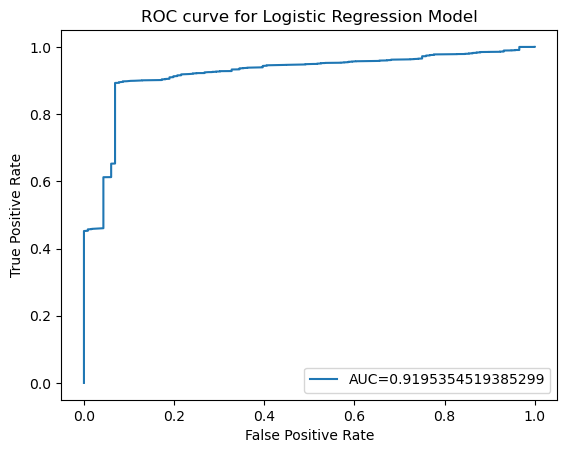

In [32]:
logreg02 = LogisticRegression()
logreg02.fit(X_train, y_train)
y_pred_proba = logreg02.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr,label="AUC="+str(auc))
plt.title('ROC curve for Logistic Regression Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The plot shows a high area under the ROC curve (AUC) which indicates that the model performed well at differentiate between the classes across different thresholds.

**Model 2: XGBoost**

In [33]:
# Train XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, xgb_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.06%


In [34]:
xgb_cm =confusion_matrix(y_test, xgb_preds)
TN = nb_cm[0][0]
FP = nb_cm[0][1]
FN = nb_cm[1][0]
TP = nb_cm[1][1]

xgb_metrics = calculate_metrics("xgb1", TN, FP, FN, TP)
xgb_metrics

,Metric,xgb1 Values
0,Accuracy,0.956671
1,Error Rate,0.043329
2,Sensitivity,0.958469
3,Specificity,0.327586
4,Precision,0.997999
5,Recall,0.958469
6,F1 Score,0.977835
7,F2 Score,0.966122
8,F0.5 Score,0.989835


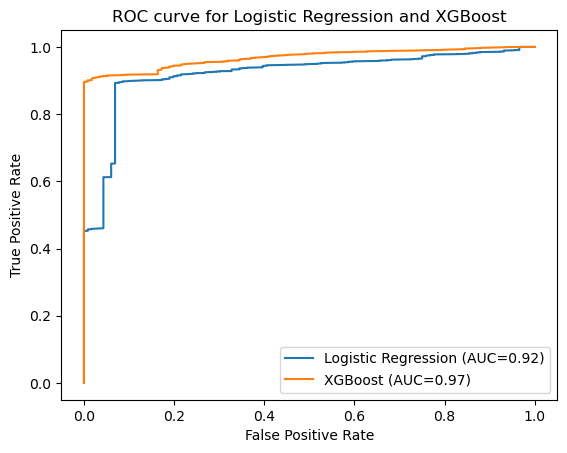

In [35]:
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score



# Predict probabilities for XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate FPR and TPR for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Plot ROC curve for Logistic Regression
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={auc:.2f})")

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.2f})")

plt.title('ROC curve for Logistic Regression and XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()